# Grid Angle Differencing Topology

This notebook explores the question: "what is the normal angle profile delta across the grid?" We note that power flows "downhill" from large angles to small angles. Deltas between angles and a reference point shows the downhill gradient. If we know "normal" (e.g. angle baselining) we can watch for "angle walkout" -- the cause of every major blackout. 

It has been noted in the past that deviation from normal angle baseline is a failure condition; however this condition is a slowly moving thing. Approaches in the past have used simulation to determine normality, but we propose to do it with measurement data. This then becomes both an operational and planning tool. On the operational side you can detect walkouts through visualization.  On the planning side you can use the baselines to detect asset failures and perform preventative maintenance.

Computation:

1. Unwrap phase angles
2. Referencing (might be optional)
3. Differencing (pairwise differences between all angles)

## Dataset 

Because this analytic requires a read of _all positive sequence voltage phase angles_, we do not access the data directly from the database. Instead we use the `extract` module to generate an Arrow table as follows:

```
$ python -m extract --help
```

Save the resulting output to the `data/` directory and it can be loaded by this notebook.

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt

from operator import mul
from matplotlib import animation
from dotenv import load_dotenv, find_dotenv
from btrdb.utils.timez import ns_to_datetime, ns_delta

In [2]:
DATA_PATH = "data/p1ang20180912-1300.arrow"

def read_data(path=DATA_PATH):
    with pa.OSFile(path, 'rb') as f:
        reader = pa.RecordBatchStreamReader(f)
        table = reader.read_all()
        return table.to_pandas()

    
data = read_data()

In [3]:
data.head()

,dd705ce2-075c-4997-bb78-a756c38f84b2,1cc66d1b-801e-49fb-8b52-f023d83f4131,dbdb0f58-f854-4f4c-822b-466aae50a23d,2dde06f4-4141-4bd5-9e71-cda40043d487,b2e0b02c-3b97-4160-a852-76cdff542e1b,10f47a76-f8e0-4223-b9a3-e64f8d0dfd17,6a065019-97a1-434c-b412-9ebde389b036,7fa46af6-6b8d-49e1-adea-36f2c629dc81,fb270950-3363-4ef4-8837-4993b6b07516,d24f6bcb-9b13-4570-880c-9b4a8d27f5e7,...,41e04a5f-aa98-4cfa-ae76-e0750d7f0975,15a4ff8a-2ece-46f9-a7a4-eae00516e183,4daa4445-5b3e-4775-9203-63007dac0327,750a7a9b-1bdc-4727-8b3e-ac36927abad2,bb9a7246-d2ec-4c08-938a-d158cf4f3d5d,ee030233-1cdf-48ea-9d50-0be737f9520c,d297d18f-f79f-4b6a-9271-53e744fc8326,10ded5c7-af7c-4ec4-be0b-2bc0c85132ce,1b4b47d0-61ac-44e4-9c16-39f117a90610,9a15bad4-b3c0-484f-9639-88978de32f07
time,,,,,,,,,,,,,,,,,,,,,
1536757200000000000,-125.2445,69.15207,-125.1931,-120.8014,-122.6920,-125.4250,63.43495,180.0,-135.0,0.0,...,-130.2884,-128.0009,48.06229,52.12055,-130.3101,-130.1879,69.15764,0.0,-114.7362,0.0
1536757200033000000,-125.3221,69.32297,-125.2736,-120.8579,-122.7431,-125.5056,63.43495,0.0,-135.0,0.0,...,-130.3521,-128.1230,47.93481,52.02643,-130.3742,-130.2543,69.01452,0.0,-114.8310,0.0
1536757200066000000,-125.4102,69.27070,-125.3636,-120.9230,-122.8339,-125.5957,63.43495,0.0,-135.0,0.0,...,-130.4398,-128.2110,47.93827,51.99497,-130.4614,-130.3391,68.92999,0.0,-114.9259,0.0
1536757200100000000,-125.5064,69.13238,-125.4597,-121.0044,-122.8890,-125.6889,63.43495,0.0,-135.0,0.0,...,-130.5327,-128.3063,47.83545,51.88296,-130.5567,-130.4371,68.82921,0.0,-115.0241,0.0
1536757200133000000,-125.6027,69.21818,-125.5537,-121.1102,-122.9635,-125.7881,63.43495,0.0,-135.0,0.0,...,-130.6338,-128.4016,47.76479,51.80263,-130.6605,-130.5381,68.74481,0.0,-115.1189,0.0


In [4]:
# The number of rows by the number of streams
data.shape

(27041, 107)

## Data Wrangling

The export script is optimistic and gets as much data from the database as it can. Unfortunately this does not necessarily lead to a dataset that's ready for angle differencing.

### Deduplication

We've noticed that some streams have multiple phase angle values for a single timestamp, which adds many `np.nan` values artificially; we handle this by selecting the first row of the duplicates, which presumably has more values.

In [5]:
def deduplicate(df):
    dups = df.index.duplicated(keep='first')
    print(f"{dups.sum()} duplicated rows in dataset")
    df = df[~dups]
    print(f"new shape is {df.shape}")
    return df

data = deduplicate(data)

41 duplicated rows in dataset
new shape is (27000, 107)


### Null Values

Null values such as `np.nan` or a stream that consists solely of 0 values may need to be dropped from the angle differencing computation.

In [6]:
def null_values(df):
    nulls = df.isnull().sum()
    total = mul(*df.shape)
    print(f"{nulls.sum():,} null values ({(nulls.sum()/total)*100:0.2f}% of data)")
    print(f"{len(nulls[nulls==0])} columns with complete data")
    print(f"{len(nulls[nulls>len(df)/2])} columns with > 50% of data missing")
    print(f"{len(nulls[(nulls>0)&(nulls<=len(df)/2)])} columns with <= 50% of data missing")
    return nulls

nulls = null_values(data)

303,602 null values (10.51% of data)
42 columns with complete data
11 columns with > 50% of data missing
54 columns with <= 50% of data missing


In [7]:
nulls.describe()

count      107.000000
mean      2837.401869
std       8220.290173
min          0.000000
25%          0.000000
50%          2.000000
75%         46.000000
max      27000.000000
dtype: float64

In [8]:
def drop_null_columns(df, thresh=0.5):
    """
    Drop columns who number of null rows is greater than the 
    threshold percentage. 
    """
    nulls = df.isnull().sum()
    keep = nulls[nulls<=(len(df)*thresh)].index
    return df[keep]

data = drop_null_columns(data)
data = data.dropna()

### Data Reduction

Reduce data to just one minute for simplification of the initial analysis.

In [9]:
data = data.truncate(after=data.index[0]+ns_delta(minutes=1))
data.shape

(1773, 96)

## Angle Differencing

Given a 2D array where the rows are timestamps and the columns are voltage positive sequence phase angles, return a 3D array where the frames are the pairwise angle differences and the stack is time.

The first step is unwrapping the angles -- note that the unwrapping step will perform some data wrangling that may be undesirable: 

1. It will drop any columns that are completely null
2. It will replace `np.nan` and `None` with `0.0`

In [10]:
def unwrap(df):
    """
    Unwrap angles by column and return an unwrapped dataframe
    with the same time index as the original dataframe. 
    
    Note that unwrapping will convert np.nan or None into zero.
    This will also remove columns with no data in them at all.
    """
    columns = []
    # WARNING: Do not use df.apply -- the kernel crashes?!
    for name in df.columns:
        column = df[name]
        column = np.deg2rad(column, where=~column.isnull())
        if column.isnull().sum() < len(column):
            column = pd.Series(np.unwrap(column), name=column.name, index=column.index)
            columns.append(column)
    return pd.concat(columns, axis=1)


angs = unwrap(data)

In [11]:
angs.head()

,dd705ce2-075c-4997-bb78-a756c38f84b2,1cc66d1b-801e-49fb-8b52-f023d83f4131,dbdb0f58-f854-4f4c-822b-466aae50a23d,2dde06f4-4141-4bd5-9e71-cda40043d487,b2e0b02c-3b97-4160-a852-76cdff542e1b,10f47a76-f8e0-4223-b9a3-e64f8d0dfd17,6a065019-97a1-434c-b412-9ebde389b036,7fa46af6-6b8d-49e1-adea-36f2c629dc81,fb270950-3363-4ef4-8837-4993b6b07516,d24f6bcb-9b13-4570-880c-9b4a8d27f5e7,...,41e04a5f-aa98-4cfa-ae76-e0750d7f0975,15a4ff8a-2ece-46f9-a7a4-eae00516e183,4daa4445-5b3e-4775-9203-63007dac0327,750a7a9b-1bdc-4727-8b3e-ac36927abad2,bb9a7246-d2ec-4c08-938a-d158cf4f3d5d,ee030233-1cdf-48ea-9d50-0be737f9520c,d297d18f-f79f-4b6a-9271-53e744fc8326,10ded5c7-af7c-4ec4-be0b-2bc0c85132ce,1b4b47d0-61ac-44e4-9c16-39f117a90610,9a15bad4-b3c0-484f-9639-88978de32f07
time,,,,,,,,,,,,,,,,,,,,,
1536757200000000000,-2.185929,1.206931,-2.185032,-2.108382,-2.141379,-2.189079,1.107149,3.141593,-2.356194,0.0,...,-2.273962,-2.234037,0.838845,0.909675,-2.274340,-2.272208,1.207029,0.0,-2.002524,0.0
1536757200033000000,-2.187283,1.209914,-2.186437,-2.109368,-2.142271,-2.190486,1.107149,0.000000,-2.356194,0.0,...,-2.275073,-2.236168,0.836620,0.908033,-2.275459,-2.273366,1.204531,0.0,-2.004179,0.0
1536757200066000000,-2.188821,1.209002,-2.188008,-2.110504,-2.143856,-2.192058,1.107149,0.000000,-2.356194,0.0,...,-2.276604,-2.237704,0.836681,0.907483,-2.276981,-2.274846,1.203055,0.0,-2.005835,0.0
1536757200100000000,-2.190500,1.206588,-2.189685,-2.111925,-2.144818,-2.193685,1.107149,0.000000,-2.356194,0.0,...,-2.278225,-2.239367,0.834886,0.905528,-2.278644,-2.276557,1.201296,0.0,-2.007549,0.0
1536757200133000000,-2.192181,1.208085,-2.191325,-2.113772,-2.146118,-2.195417,1.107149,0.000000,-2.356194,0.0,...,-2.279990,-2.241031,0.833653,0.904126,-2.280456,-2.278320,1.199823,0.0,-2.009204,0.0


In [12]:
angs.tail()

,dd705ce2-075c-4997-bb78-a756c38f84b2,1cc66d1b-801e-49fb-8b52-f023d83f4131,dbdb0f58-f854-4f4c-822b-466aae50a23d,2dde06f4-4141-4bd5-9e71-cda40043d487,b2e0b02c-3b97-4160-a852-76cdff542e1b,10f47a76-f8e0-4223-b9a3-e64f8d0dfd17,6a065019-97a1-434c-b412-9ebde389b036,7fa46af6-6b8d-49e1-adea-36f2c629dc81,fb270950-3363-4ef4-8837-4993b6b07516,d24f6bcb-9b13-4570-880c-9b4a8d27f5e7,...,41e04a5f-aa98-4cfa-ae76-e0750d7f0975,15a4ff8a-2ece-46f9-a7a4-eae00516e183,4daa4445-5b3e-4775-9203-63007dac0327,750a7a9b-1bdc-4727-8b3e-ac36927abad2,bb9a7246-d2ec-4c08-938a-d158cf4f3d5d,ee030233-1cdf-48ea-9d50-0be737f9520c,d297d18f-f79f-4b6a-9271-53e744fc8326,10ded5c7-af7c-4ec4-be0b-2bc0c85132ce,1b4b47d0-61ac-44e4-9c16-39f117a90610,9a15bad4-b3c0-484f-9639-88978de32f07
time,,,,,,,,,,,,,,,,,,,,,
1536757259866000000,-1.055975,2.315261,-1.055136,-0.980760,-1.012197,-1.059201,2.034443,-12.566371,-0.952773,-12.566371,...,-1.145332,-1.100691,1.968168,2.036012,-1.145688,-1.143623,2.340518,0.0,-0.868982,0.0
1536757259900000000,-1.053607,2.317033,-1.052772,-0.978954,-1.009687,-1.056836,2.034443,-9.424778,-0.950587,-12.566371,...,-1.142968,-1.098645,1.970747,2.037970,-1.143412,-1.141289,2.342757,0.0,-0.866545,0.0
1536757259933000000,-1.051327,2.318670,-1.050529,-0.976692,-1.008132,-1.054590,2.034443,-12.566371,-0.948388,-12.566371,...,-1.140744,-1.097292,1.972573,2.040711,-1.141158,-1.139068,2.344443,0.0,-0.864241,0.0
1536757259966000000,-1.048966,2.322079,-1.048140,-0.974428,-1.005624,-1.052143,2.034443,-12.566371,-0.946055,-12.566371,...,-1.138315,-1.094242,1.974398,2.043068,-1.138703,-1.136615,2.347246,0.0,-0.861797,0.0
1536757260000000000,-1.046428,2.327044,-1.045607,-0.972377,-1.002854,-1.049607,2.034443,-12.566371,-0.943610,-12.566371,...,-1.135654,-1.092544,1.976872,2.044268,-1.136044,-1.133956,2.349484,0.0,-0.859402,0.0


<IPython.core.display.Javascript object>


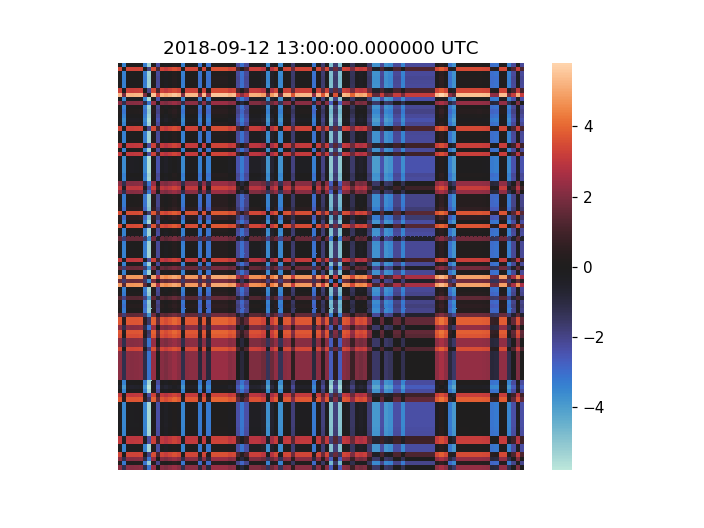

In [13]:
def heatmap(ts, df):
    # This is the angle differencing code
    frame = df.loc[ts]
    diffs = np.vstack(frame.values) - frame.values
    plt.clf()
    g = sns.heatmap(diffs, center=0, square=True)
    g.set_xticks([])
    g.set_yticks([])
    g.set_title(ns_to_datetime(frame.name).strftime("%Y-%m-%d %H:%M:%S.%f UTC"))
    return g

_ = heatmap(1536757200000000000, angs)

<IPython.core.display.Javascript object>


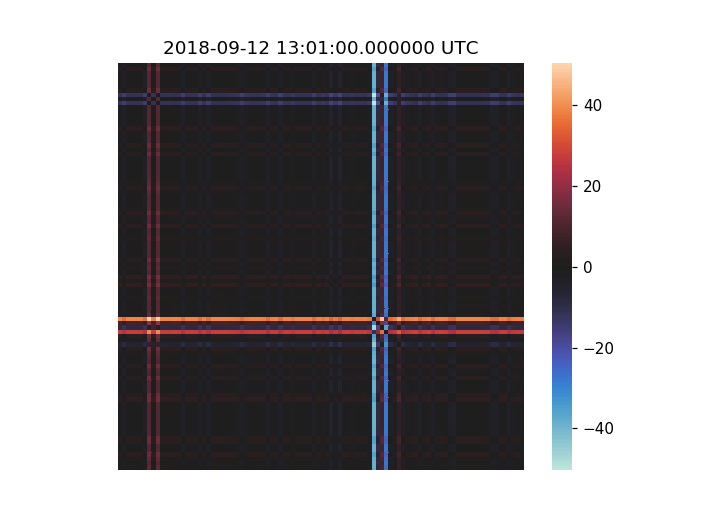

In [14]:
def animate(df):
    """
    Animate the angle differences
    """
    fig = plt.figure()
    ani = animation.FuncAnimation(
        fig, heatmap, df.index[1:], fargs=(df,),
        init_func=lambda: heatmap(df.index[0], df), repeat=False
    )
        
    writer = animation.FFMpegWriter(fps=30)
    ani.save("angdiff.mp4", writer=writer)

    
animate(angs)